In [5]:
# 1. Import libraries we need

import pandas as pd                        # data handling
import numpy as np                         # numeric helpers
import re                                   # regex for text cleaning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

In [7]:
# 2. Load the CSV from the path you gave
df = pd.read_csv("/content/emails_spam.csv")
df.head()

# 3. Quick peek
print("Shape:", df.shape)
print(df.columns)   # shows column names so you can confirm which to use
df.head(2)


Shape: (5172, 3002)
Index(['Email No.', 'the', 'to', 'ect', 'and', 'for', 'of', 'a', 'you', 'hou',
       ...
       'connevey', 'jay', 'valued', 'lay', 'infrastructure', 'military',
       'allowing', 'ff', 'dry', 'Prediction'],
      dtype='object', length=3002)


Email No.  the  to  ect  and  for  of    a  you  hou  ...  connevey  jay  \
0   Email 1    0   0    1    0    0   0    2    0    0  ...         0    0   
1   Email 2    8  13   24    6    6   2  102    1   27  ...         0    0   

   valued  lay  infrastructure  military  allowing  ff  dry  Prediction  
0       0    0               0         0         0   0    0           0  
1       0    0               0         0         0   1    0           0  

[2 rows x 3002 columns]


# **2) Inspect & fix column names**

In [19]:
# This cell is no longer needed as we are directly defining X and y.
# For the current dataset, the text content is already vectorized into feature columns.

# **3) Basic cleaning & check missing values**

In [25]:
# 1. Drop the 'Email No.' column as it's just an identifier and not a feature
df_processed = df.drop(columns=['Email No.'])

# 2. Separate features (X) and target (y)
X = df_processed.drop(columns=['Prediction'])
y = df_processed['Prediction']

# 3. Convert labels to a simple numerical form
le = LabelEncoder()
y_encoded = le.fit_transform(y.astype(str))
print("Label classes (encoded):", dict(zip(le.classes_, le.transform(le.classes_))))
print(pd.Series(y_encoded).value_counts()) # Use pd.Series to get value_counts for the array

# Update y to be the encoded version as a Series for consistency
y = pd.Series(y_encoded, name='label_enc')

# The clean_text function and its application are no longer needed
# as the dataset is already pre-vectorized.
# We no longer need a 'clean_text' column.

Label classes (encoded): {'0': np.int64(0), '1': np.int64(1)}
0    3672
1    1500
Name: count, dtype: int64


# **4) Train-test split**

In [21]:
# The X and y are already correctly defined from the previous cell.

# split: 80% train, 20% test, stratify to keep class balance in both parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))

Train size: 4137 Test size: 1035


# **5) Feature extraction — TF-IDF**

In [13]:
# Use TfidfVectorizer which converts text to a matrix of TF-IDF features
# stop_words='english' uses built-in list, keep max_features small if you want speed
tfidf = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=3, token_pattern=r'(?u)\b\w+\b')

# Fit on training text and transform both train and test
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF matrix shape (train):", X_train_tfidf.shape)


TF-IDF matrix shape (train): (4136, 2)


# **6) Model 1 — Multinomial Naive Bayes (simple and fast)**

In [22]:
nb = MultinomialNB()
nb.fit(X_train, y_train)   # train model directly on X_train

y_pred_nb = nb.predict(X_test)            # predicted classes
y_proba_nb = nb.predict_proba(X_test)[:, 1]  # probability for positive class

print("Naive Bayes - classification report:")
print(classification_report(y_test, y_pred_nb, digits=4))

Naive Bayes - classification report:
              precision    recall  f1-score   support

           0     0.9760    0.9415    0.9584       735
           1     0.8681    0.9433    0.9042       300

    accuracy                         0.9420      1035
   macro avg     0.9221    0.9424    0.9313      1035
weighted avg     0.9447    0.9420    0.9427      1035



# **7) Model 2 — Logistic Regression (strong baseline)**

In [23]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train) # train model directly on X_train

y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression - classification report:")
print(classification_report(y_test, y_pred_lr, digits=4))

Logistic Regression - classification report:
              precision    recall  f1-score   support

           0     0.9931    0.9823    0.9877       735
           1     0.9578    0.9833    0.9704       300

    accuracy                         0.9826      1035
   macro avg     0.9755    0.9828    0.9790      1035
weighted avg     0.9829    0.9826    0.9827      1035



# **8) Confusion matrix and ROC AUC**

Naive Bayes confusion matrix:
[[692  43]
 [ 17 283]]
Logistic Regression confusion matrix:
[[722  13]
 [  5 295]]
Naive Bayes ROC AUC: 0.9742471655328798
Logistic Regression ROC AUC: 0.9920272108843539


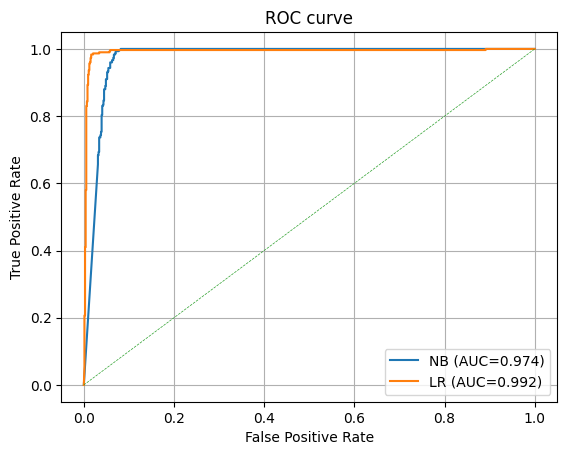

In [24]:
# Confusion matrix for the best model you like (compare both)
print("Naive Bayes confusion matrix:")
print(confusion_matrix(y_test, y_pred_nb))

print("Logistic Regression confusion matrix:")
print(confusion_matrix(y_test, y_pred_lr))

# ROC AUC
# For binary classification, y_proba_nb and y_proba_lr (probabilities for positive class) are directly usable.
print("Naive Bayes ROC AUC:", roc_auc_score(y_test, y_proba_nb))
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, y_proba_lr))

# If you want to plot ROC curve (optional)
import matplotlib.pyplot as plt
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)

plt.plot(fpr_nb, tpr_nb, label='NB (AUC={:.3f})'.format(roc_auc_score(y_test, y_proba_nb)))
plt.plot(fpr_lr, tpr_lr, label='LR (AUC={:.3f})'.format(roc_auc_score(y_test, y_proba_lr)))
plt.plot([0,1],[0,1],'--', linewidth=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.grid(True)
plt.show()

## **9) Quick utility: show top features for Logistic Regression**

In [27]:
# show top positive and negative words for Logistic Regression
feature_names = X.columns # Correctly get feature names from the DataFrame columns
coefs = lr.coef_[0]   # coefficient per feature

# top 15 spammy words (largest positive coefficients)
top_spam_idx = np.argsort(coefs)[-15:][::-1]
top_ham_idx = np.argsort(coefs)[:15]

print("Top words indicating SPAM:")
for i in top_spam_idx:
    print(feature_names[i], round(coefs[i], 4))

print("\nTop words indicating NOT-SPAM (ham):")
for i in top_ham_idx:
    print(feature_names[i], round(coefs[i], 4))


Top words indicating SPAM:
http 0.7879
only 0.7848
z 0.7309
message 0.7034
mo 0.6523
remove 0.6275
men 0.6217
gra 0.6127
my 0.592
prices 0.59
fact 0.5819
dr 0.5736
ut 0.5551
ali 0.5463
people 0.5391

Top words indicating NOT-SPAM (ham):
attached -1.2978
enron -1.188
deal -1.148
doc -1.0494
sitara -1.0389
love -0.9696
hpl -0.9068
hp -0.9065
neon -0.8655
aren -0.8028
daren -0.7906
number -0.6973
nom -0.6931
picture -0.6917
tax -0.6704


## 10) Save the best pipeline

In [29]:
import joblib
from sklearn.pipeline import Pipeline

# The data is already vectorized, so we don't need TfidfVectorizer here.
# We can create a pipeline with just the Logistic Regression model, or save the model directly.
# For consistency with the make_pipeline structure, we'll keep it as a pipeline object.
pipeline = Pipeline([
    ('logistic_regression', LogisticRegression(max_iter=1000))
])
pipeline.fit(X_train, y_train)

# Save to disk
joblib.dump(pipeline, '/content/spam_classifier_pipeline.joblib')
print("Saved pipeline to /content/spam_classifier_pipeline.joblib")

Saved pipeline to /content/spam_classifier_pipeline.joblib
